In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

### Load Data

In [2]:
def load_data(flepath, well_names_col, well_name, prod_col_name, date_col_name):
    df = pd.read_excel(flepath, parse_dates=True)
    
    df = df[df[well_names_col] == well_name][[date_col_name, prod_col_name]]
    
    df.columns = ["date", "production"]
    
    return df

In [3]:
df = load_data('Volve production data.xlsx', 'NPD_WELL_BORE_NAME', '15/9-F-14', 'BORE_OIL_VOL', 'DATEPRD')
df.head()

,date,production
4967,2008-02-12,0.0
4968,2008-02-13,0.0
4969,2008-02-14,0.0
4970,2008-02-15,0.0
4971,2008-02-16,0.0


In [4]:
assert len(df.columns) == 2 , "make sure your dataframe has only 2 columns"
assert list(df.columns) == ["date", "production"], "make sure your dataframe has columns named 'date' and 'production'"

<Axes: xlabel='date'>

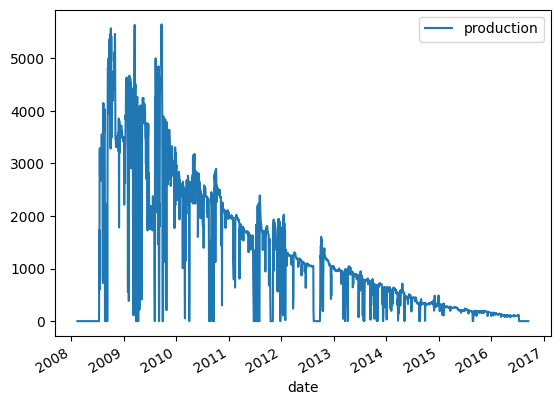

In [5]:
df.plot(x="date", y="production")

### Remove the outliers

In [6]:
def remove_outliers(df, col_name="production"):
    
    df = df[df[col_name] != 0]
    
    return df

In [7]:
df_removed = remove_outliers(df)
df_removed.head()

,date,production
5118,2008-07-13,1735.26
5119,2008-07-14,592.36
5120,2008-07-15,2532.21
5121,2008-07-16,3030.71
5122,2008-07-17,3288.08


In [8]:
assert len(df_removed) != len(df), "make sure you removed the outliers"

### Data Smoothing

In [9]:
def smooth(df, col_name="production", window_size=100):
    
    df[col_name+"_smoothed"] = df[col_name].rolling(window=window_size, center=True).mean()
    
    df = df.dropna()
    
    return df

In [10]:
df_smoothed = smooth(df_removed, "production", window_size=100)
df_smoothed.head()

C:\Users\Hary Capri\AppData\Local\Temp\ipykernel_4060\64648518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name+"_smoothed"] = df[col_name].rolling(window=window_size, center=True).mean()


,date,production,production_smoothed
5179,2008-09-13,4925.62,3809.6498
5180,2008-09-14,4963.82,3829.6124
5181,2008-09-15,4970.38,3858.4468
5182,2008-09-16,4982.77,3867.7339
5183,2008-09-17,5003.65,3872.0095


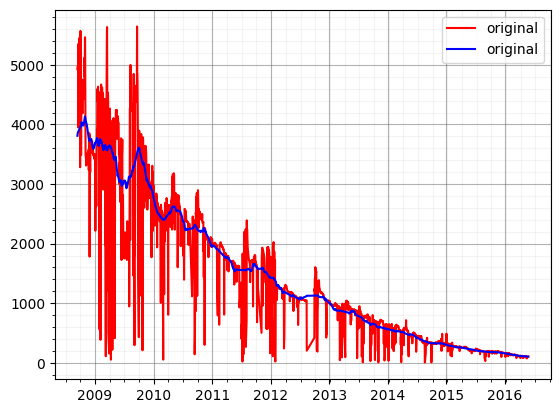

In [11]:
plt.plot(df_smoothed["date"], df_smoothed["production"], label="original", color="red")
plt.plot(df_smoothed["date"], df_smoothed["production_smoothed"], label="original", color="blue")

plt.legend(loc="upper right")

plt.grid(which="major", color="#666666", linestyle="-", alpha=.5)
plt.grid(which="minor", color="#9999", linestyle="-", alpha=.1)

plt.minorticks_on()


In [16]:
import importlib
import arps as arps_mod
importlib.reload(arps_mod)


<module 'arps' from 'c:\\Users\\Hary Capri\\OneDrive\\Desktop\\Joki Proyek\\d0825007\\dca volve\\arps.py'>

In [17]:
params, vis_data = arps_mod.arps(df_smoothed, date_col="date", production_smooth_col="production_smoothed")

c:\Users\Hary Capri\OneDrive\Desktop\Joki Proyek\d0825007\dca volve\arps.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
params

,model,qi,di,b,RMSE
0,exponential,4326.783678,0.000986,0.000000,155.204196
1,harmonic,4901.064453,0.002292,1.000000,389.266554
2,hyperbolic,4072.613254,0.000745,-0.338553,108.953447


<Axes: xlabel='Time'>

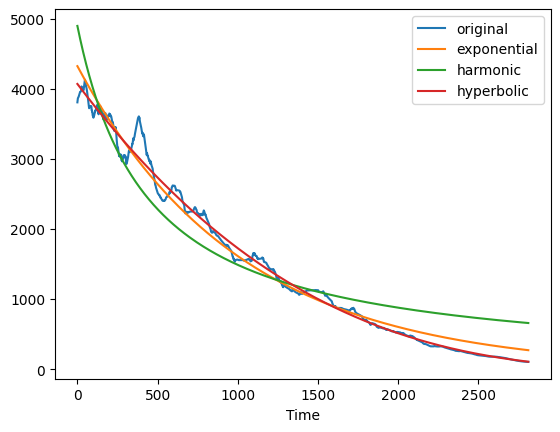

In [19]:
vis_data.plot()

In [119]:
assert len(df_removed) != len(df_smoothed)
assert list(df_smoothed.columns) == ["date", "production", "production_smoothed"]

### Getting days from the date

In [120]:
def get_days(df, col_name="date"):
    
    df["days"] = (df[col_name] - df[col_name].min()).dt.days
    
    return df

In [121]:
df_final = get_days(df_smoothed)
df_final

C:\Users\Hary Capri\AppData\Local\Temp\ipykernel_24176\3825456313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["days"] = (df[col_name] - df[col_name].min()).dt.days


,date,production,production_smoothed,days
5179,2008-09-13,4925.62,3809.6498,0
5180,2008-09-14,4963.82,3829.6124,1
5181,2008-09-15,4970.38,3858.4468,2
5182,2008-09-16,4982.77,3867.7339,3
5183,2008-09-17,5003.65,3872.0095,4
...,...,...,...,...
7903,2016-05-21,100.70,103.2273,2807
7904,2016-05-22,101.14,103.3252,2808
7905,2016-05-23,101.57,103.3933,2809
7906,2016-05-24,102.31,103.5048,2810


In [122]:
def hyperbolic(t, qi, di, b):
    return qi / (np.abs((1 + b * di * t)) ** (1 / b))

In [123]:
def exponential(t, qi, di): 
    return qi * np.exp(-di * t)

In [124]:
def harmonic(t, qi, di):
    return qi / (1 + di * t)

In [125]:
T = df_final["days"]
Q = df_final["production_smoothed"]

### Exponential fitting

In [131]:
def exponential_fitting(T, Q):
    T_normalized = T / max(T)
    Q_normalized = Q / max(Q)
    
    params , _ = curve_fit(exponential, T_normalized, Q_normalized)
    qi , di = params
    
    qi = qi * max(Q)
    di = di / max(T)
    
    return {"qi" : qi, "di" : di, "b" : 0}


In [132]:
params = exponential_fitting(T, Q)

In [133]:
params

{'qi': 4326.783677552677, 'di': 0.000986005032051806, 'b': 0}

In [134]:
Q_exp  = exponential(T, params["qi"], params["di"])

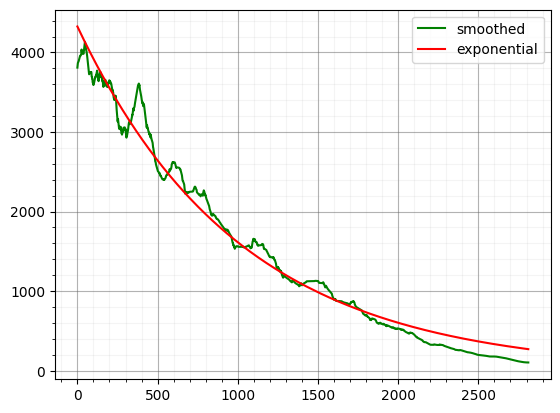

In [135]:
plt.plot(T, Q, label="smoothed", color="green")
plt.plot(T, Q_exp, label="exponential", color="red")

plt.legend()

plt.grid(which="major", color="#666666", linestyle="-", alpha=.5)
plt.grid(which="minor", color="#9999", linestyle="-", alpha=.1)

plt.minorticks_on()

plt.show()

### Model Validity

In [140]:
def error_function(original_data, model_date):
    n = len(original_data)
    RMSE = np.sqrt( (1/n) * np.square(original_data - model_date).sum())
    return RMSE

In [141]:
RMSE = error_function(Q, Q_exp)
RMSE

155.20419637371882

### Harmonic Fitting

In [156]:
def harmonic_fitting(T, Q):
    T_normalized = T / max(T)
    Q_normalized = Q / max(Q)
    
    params , _ = curve_fit(harmonic, T_normalized, Q_normalized)
    qi , di = params
    
    qi = qi * max(Q)
    di = di / max(T)
    
    return {"qi" : qi, "di" : di, "b" : 1}


In [157]:
params_h = harmonic_fitting(T, Q)

In [158]:
params_h

{'qi': 4901.0644531398075, 'di': 0.00229173289177495, 'b': 1}

In [159]:
Q_h  = harmonic(T, params_h["qi"], params_h["di"])

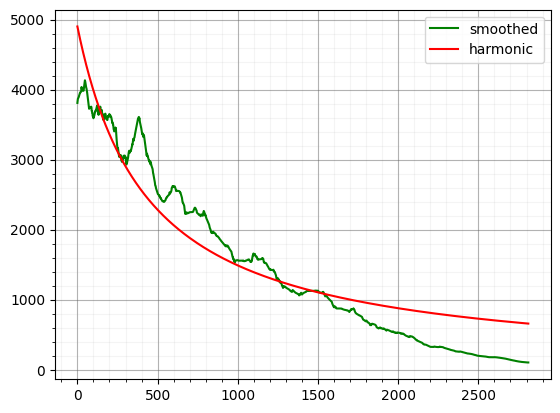

In [163]:
plt.plot(T, Q, label="smoothed", color="green")
plt.plot(T, Q_h, label="harmonic", color="red")

plt.legend()

plt.grid(which="major", color="#666666", linestyle="-", alpha=.5)
plt.grid(which="minor", color="#999999", linestyle="-", alpha=.1)

plt.minorticks_on()

plt.show()

In [170]:
RMSE_h = error_function(Q, Q_h)
RMSE_h

389.2665540101483

### Hyperbolic fitting

In [165]:
def hyperbolic_fitting(T, Q):
    T_normalized = T / max(T)
    Q_normalized = Q / max(Q)
    
    params , _ = curve_fit(hyperbolic, T_normalized, Q_normalized)
    qi , di, b = params
    
    qi = qi * max(Q)
    di = di / max(T)
    
    return {"qi" : qi, "di" : di, "b" : b}


In [166]:
params_hy = hyperbolic_fitting(T, Q)
params_hy

{'qi': 4072.6132543548815,
 'di': 0.0007447979378634339,
 'b': -0.3385530427789711}

In [167]:
Q_hy  = hyperbolic(T, params_hy["qi"], params_hy["di"], params_hy["b"])

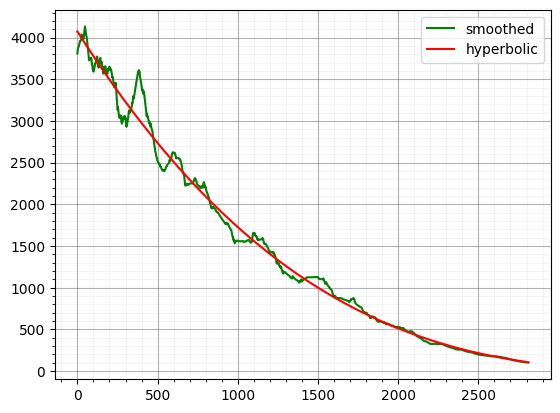

In [168]:
plt.plot(T, Q, label="smoothed", color="green")
plt.plot(T, Q_hy, label="hyperbolic", color="red")

plt.legend()

plt.grid(which="major", color="#666666", linestyle="-", alpha=.5)
plt.grid(which="minor", color="#999999", linestyle="-", alpha=.1)

plt.minorticks_on()

plt.show()

In [ ]:
RMSE_hy = error_function(Q, Q_hy)
RMSE_hy

108.9534465995579